In [1]:
from graph_tool.all import *
import graph_tool as gt

In [2]:
community_graph = gt.load_graph('PLM_community_graph_labeled.graphml')

In [3]:
[key for key in community_graph.vp.keys()]

['Component ID',
 'r',
 'size',
 'Weighted Degree',
 'y',
 '_graphml_vertex_id',
 'summary',
 'Degree',
 'label',
 'short_label',
 'x',
 'Computed Z-Level',
 'g',
 'keywords',
 'b']

In [4]:
[key for key in community_graph.ep.keys()]

['_graphml_edge_id', 'weight']

In [5]:
matrix = gt.spectral.adjacency(community_graph, weight=community_graph.ep.weight)

In [6]:
import seaborn as sns

In [9]:
matrix = matrix.todense()

In [10]:
!head ../../data/aus_to_aus/modularity_2_0_PLM.csv

0
1
2
3
4
5
6
7
7
8


In [17]:
community_graph.vp.summary.get_2d_array([0])

array([['animals', 'business digital', 'NRL', ..., '', '', '']],
      dtype='<U37')

In [18]:
import pandas as pd

In [29]:
communities = pd.read_csv('../../data/aus_to_aus/modularity_2_0_PLM.csv', header=None)
communities.columns = ['community']

In [36]:
vertex_counts = communities.groupby('community')['community'].count().values

In [62]:
community_graph.vp['vertex_count'] = community_graph.new_vertex_property('long', vals=vertex_counts)

In [63]:
community_graph_1000 = gt.GraphView(community_graph, vfilt=lambda v: community_graph.vp.vertex_count[v] >= 1000)

In [64]:
matrix = gt.spectral.adjacency(community_graph_1000, weight=community_graph.ep.weight).todense()

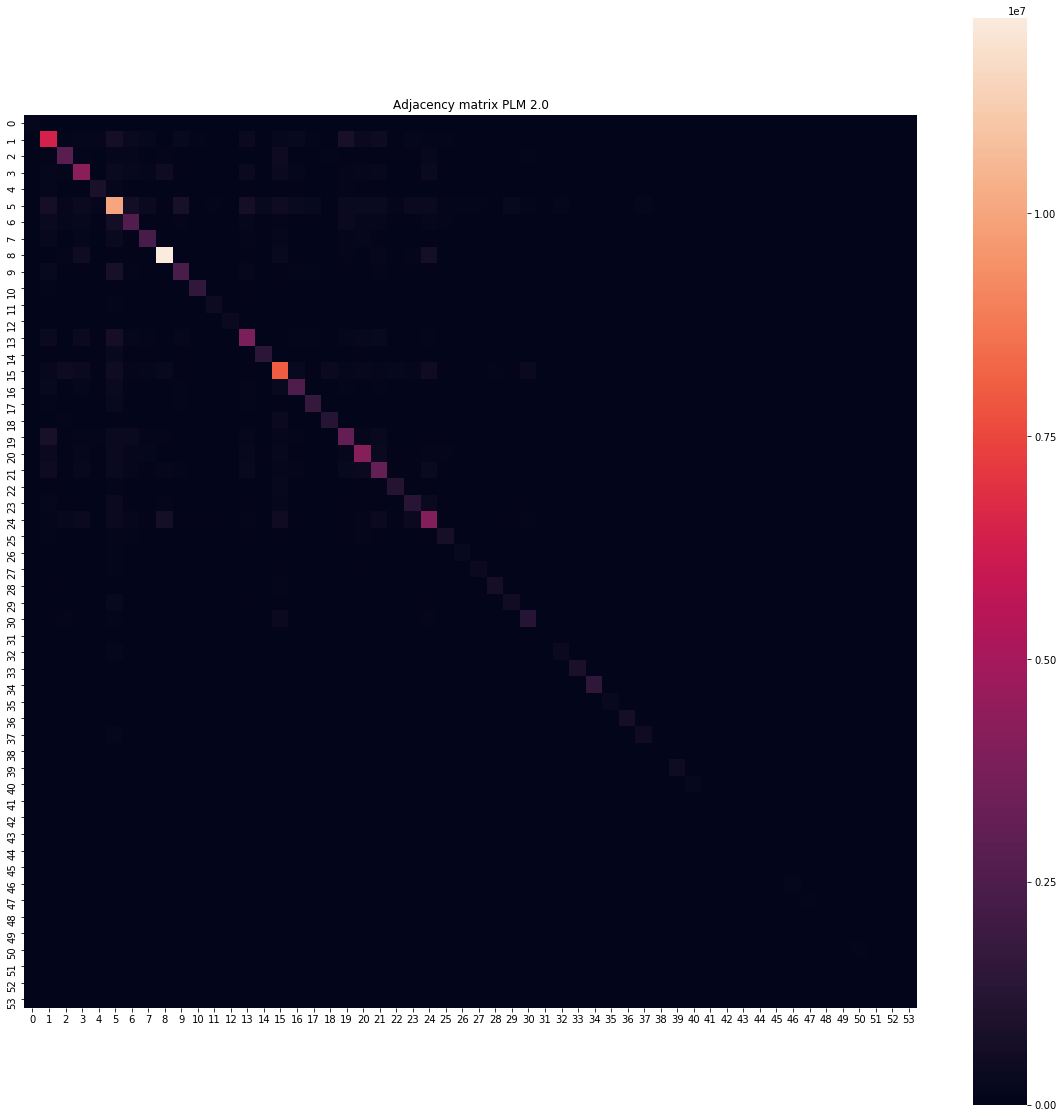

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

plt.title('Adjacency matrix PLM 2.0')

sns.heatmap(matrix, square=True, annot=False, ax=ax)

plt.show()

In [66]:
import numpy as np

numbers = community_graph_1000.vp.vertex_count.a
numbers = numbers[numbers >= 1000]
numbers.shape = (len(numbers), 1)  # make column vector

max_possible_links = np.dot(numbers, numbers.transpose())

In [67]:
normed_matrix = matrix / max_possible_links

In [68]:
max_possible_links

PropertyArray([[  116964225,  1757015715,   943889940, ...,    17920455,
                   11983020,    17606820],
               [ 1757015715, 26393576521, 14178946236, ...,   269197877,
                  180006788,   264486508],
               [  943889940, 14178946236,  7617100176, ...,   144616332,
                   96701808,   142085328],
               ..., 
               [   17920455,   269197877,   144616332, ...,     2745649,
                    1835956,     2697596],
               [   11983020,   180006788,    96701808, ...,     1835956,
                    1227664,     1803824],
               [   17606820,   264486508,   142085328, ...,     2697596,
                    1803824,     2650384]])

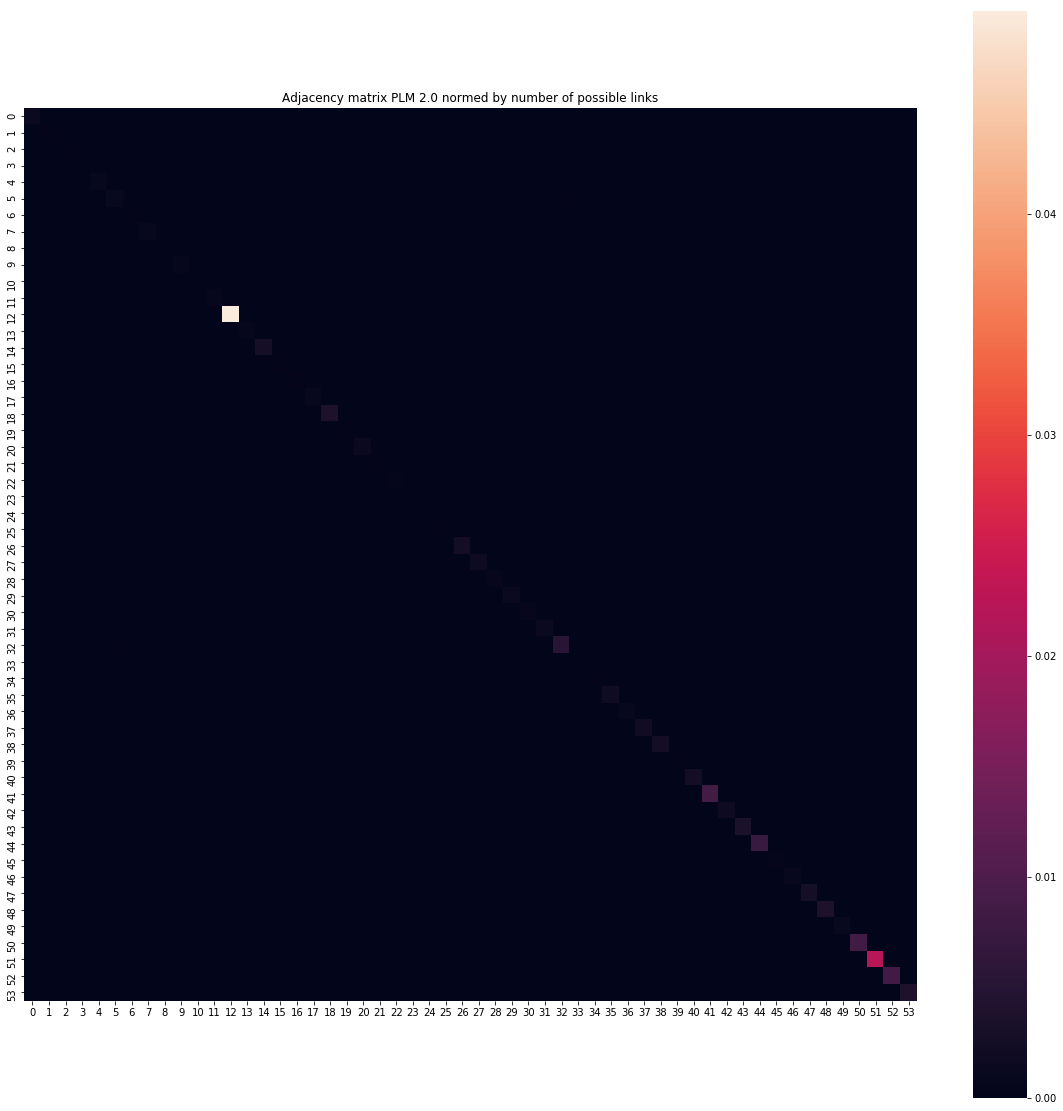

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

plt.title('Adjacency matrix PLM 2.0 normed by number of possible links')

sns.heatmap(normed_matrix, square=True, annot=False, ax=ax)

plt.show()

In [131]:
community_graph.vp.summary.get_2d_array([0])[0][[0,2,0]]

array(['animals', 'NRL', 'animals'],
      dtype='<U37')

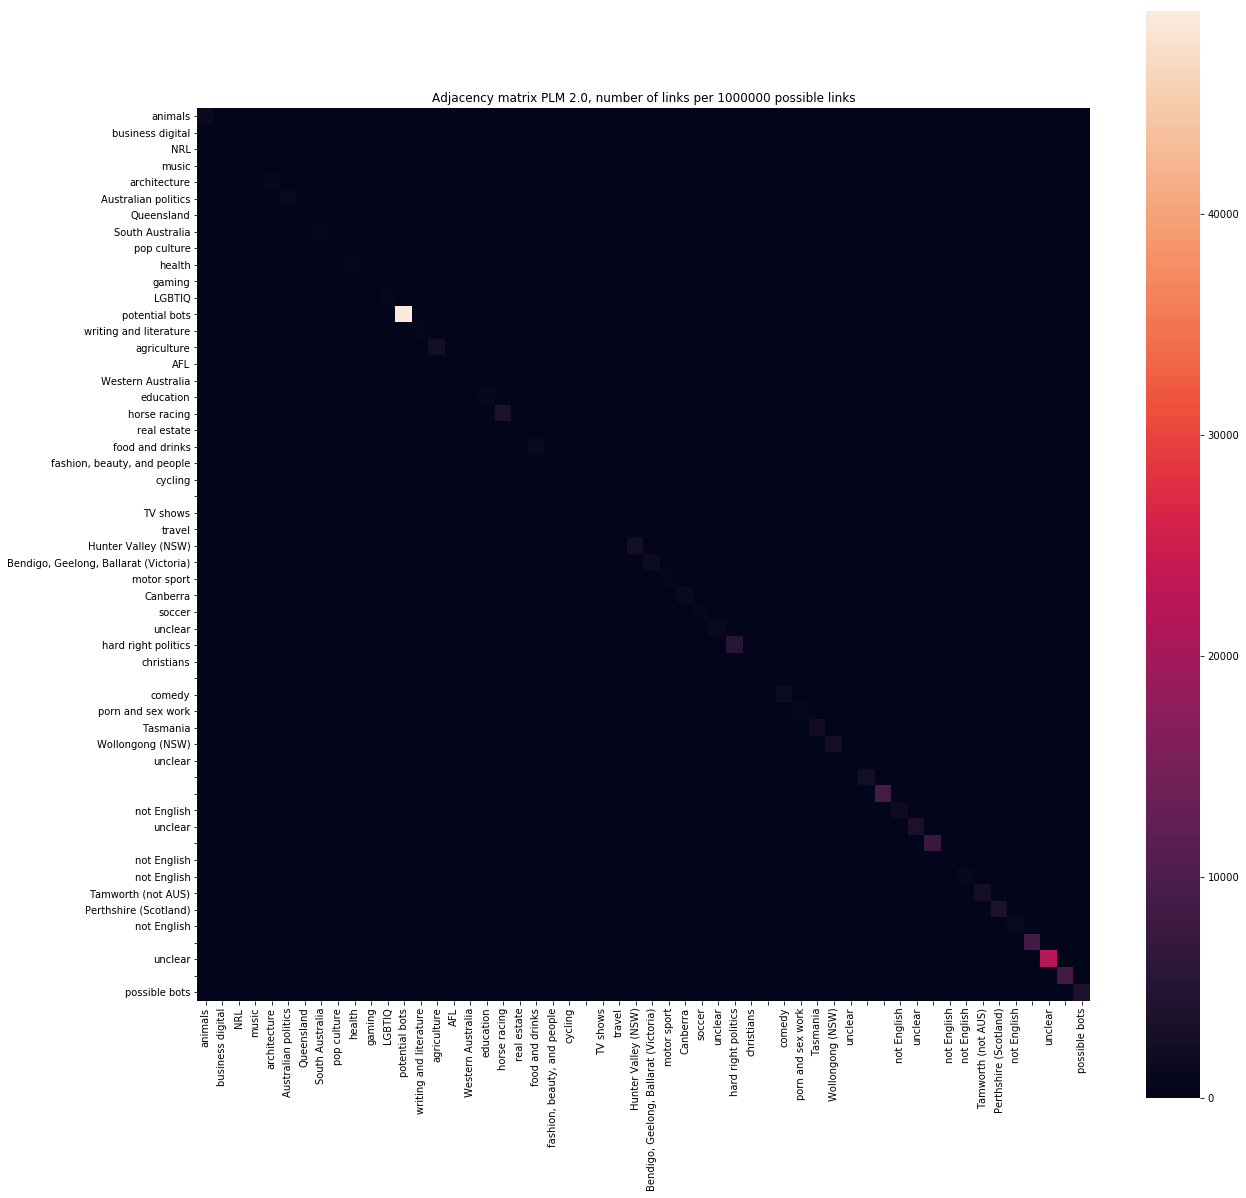

In [201]:
def plot_filtered(matrix, numbers, filter_groups=[], log=False, per=1):
    matrix_mask = np.ones(matrix.shape, dtype=bool) 
    matrix_mask[[filter_groups]] = False
    matrix_mask[:, [filter_groups]] = False

    vector_mask = np.ones(numbers.shape, dtype=bool)
    vector_mask[[filter_groups]] = False

    numbers = numbers[vector_mask]
    numbers.shape = (len(numbers), 1)
    matrix = matrix[matrix_mask].reshape((len(numbers), len(numbers)))

    labels = [i for i in range(len(numbers) + len(filter_groups)) if i not in filter_groups]
    labels = community_graph.vp.summary.get_2d_array([0])[0][labels]

    max_possible_links = np.dot(numbers, numbers.transpose())  
    # (a,b,c) (a,     aa ab ac
    #          b, = ( ba bb bc )
    #          c)     ca cb cc

    normed_matrix = per * (matrix / max_possible_links)
    
    if log is True:
        normed_matrix = np.log10(normed_matrix + 1)
    
    fig, ax = plt.subplots(figsize=(20,20))
    
    if log is True:
        ticks = np.arange(0, int(normed_matrix.max()) +1)
        plt.title('Adjacency matrix PLM 2.0, log_10 of number of links (+ 1) per {} possible links'.format(per))
        sns.heatmap(normed_matrix, square=True, annot=False, ax=ax, xticklabels=labels, yticklabels=labels,
                    cbar_kws={'ticks': ticks}
                   )
    else:
        plt.title('Adjacency matrix PLM 2.0, number of links per {} possible links'.format(per))
        sns.heatmap(normed_matrix, square=True, annot=False, ax=ax, xticklabels=labels, yticklabels=labels)

    plt.show()

plot_filtered(matrix, numbers, per=1000000)

In [202]:
def get_filter_indices(filter_strings):
    result = community_graph.vp.summary.get_2d_array([0])[0][:len(numbers)]
    result = np.where(np.isin(result, filter_strings))[0]
    return result.tolist()

print(get_filter_indices(['', 'not English', 'unclear', 'possible bots', None]))

community_graph.vp.summary.get_2d_array([0])[0][get_filter_indices(['', 'not English', 'unclear', 'possible bots'])]

[23, 31, 34, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53]


array(['', 'unclear', '', 'unclear', '', '', 'not English', 'unclear', '',
       'not English', 'not English', 'not English', '', 'unclear', '',
       'possible bots'],
      dtype='<U37')

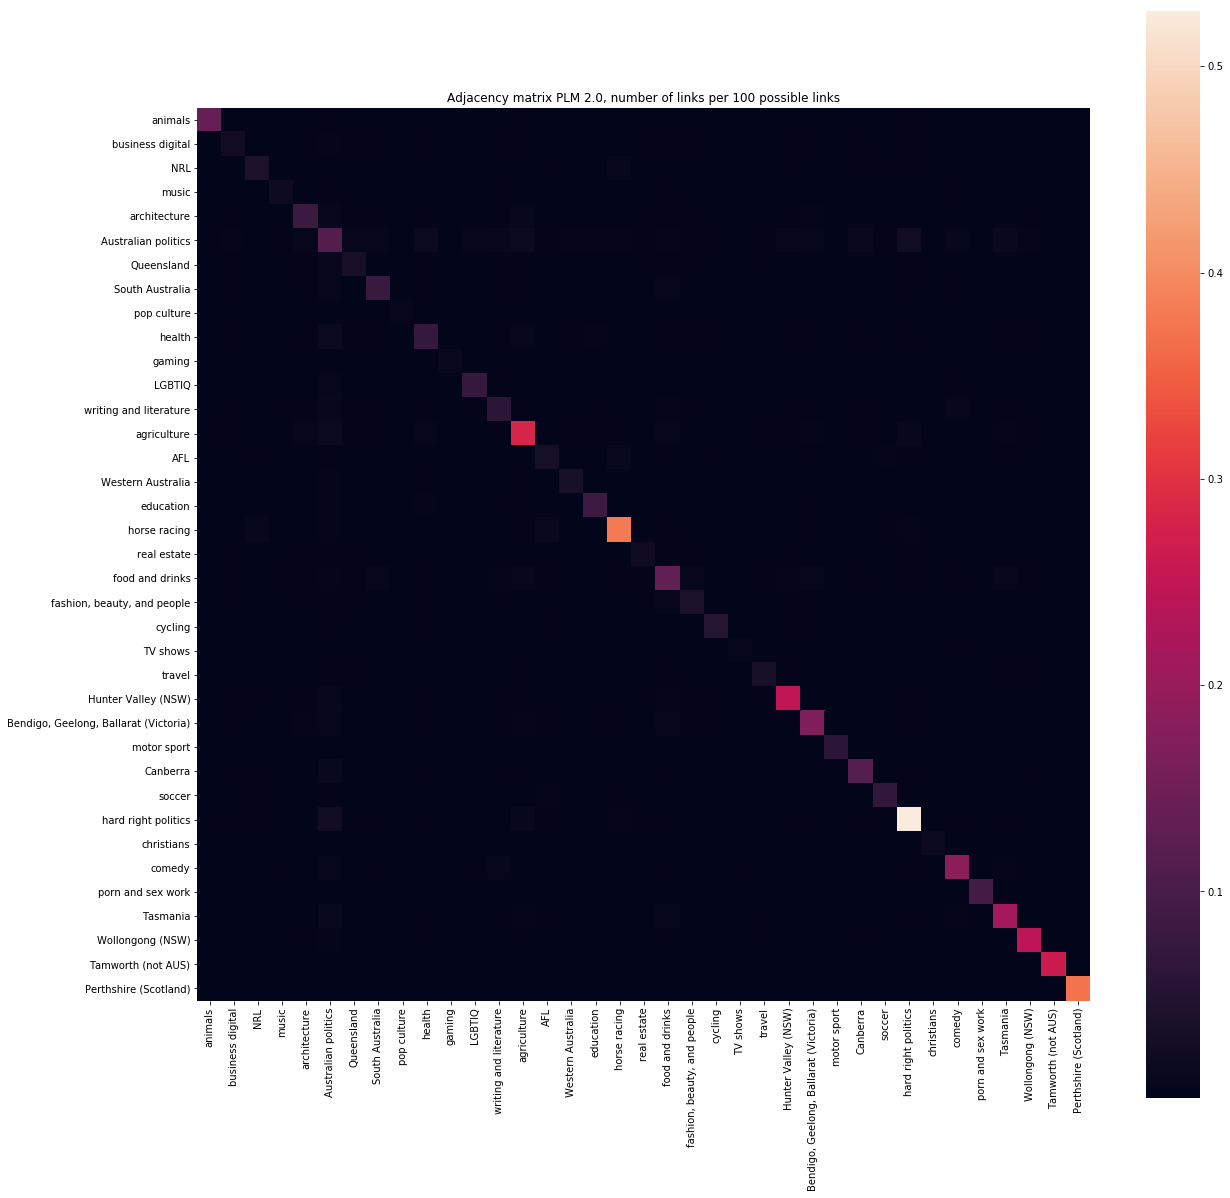

In [203]:
filter_strings = ['', 'not English', 'unclear', 'possible bots', 'potential bots']

filter_groups = get_filter_indices(filter_strings)

plot_filtered(matrix, numbers, log=False, per=100, filter_groups=filter_groups)

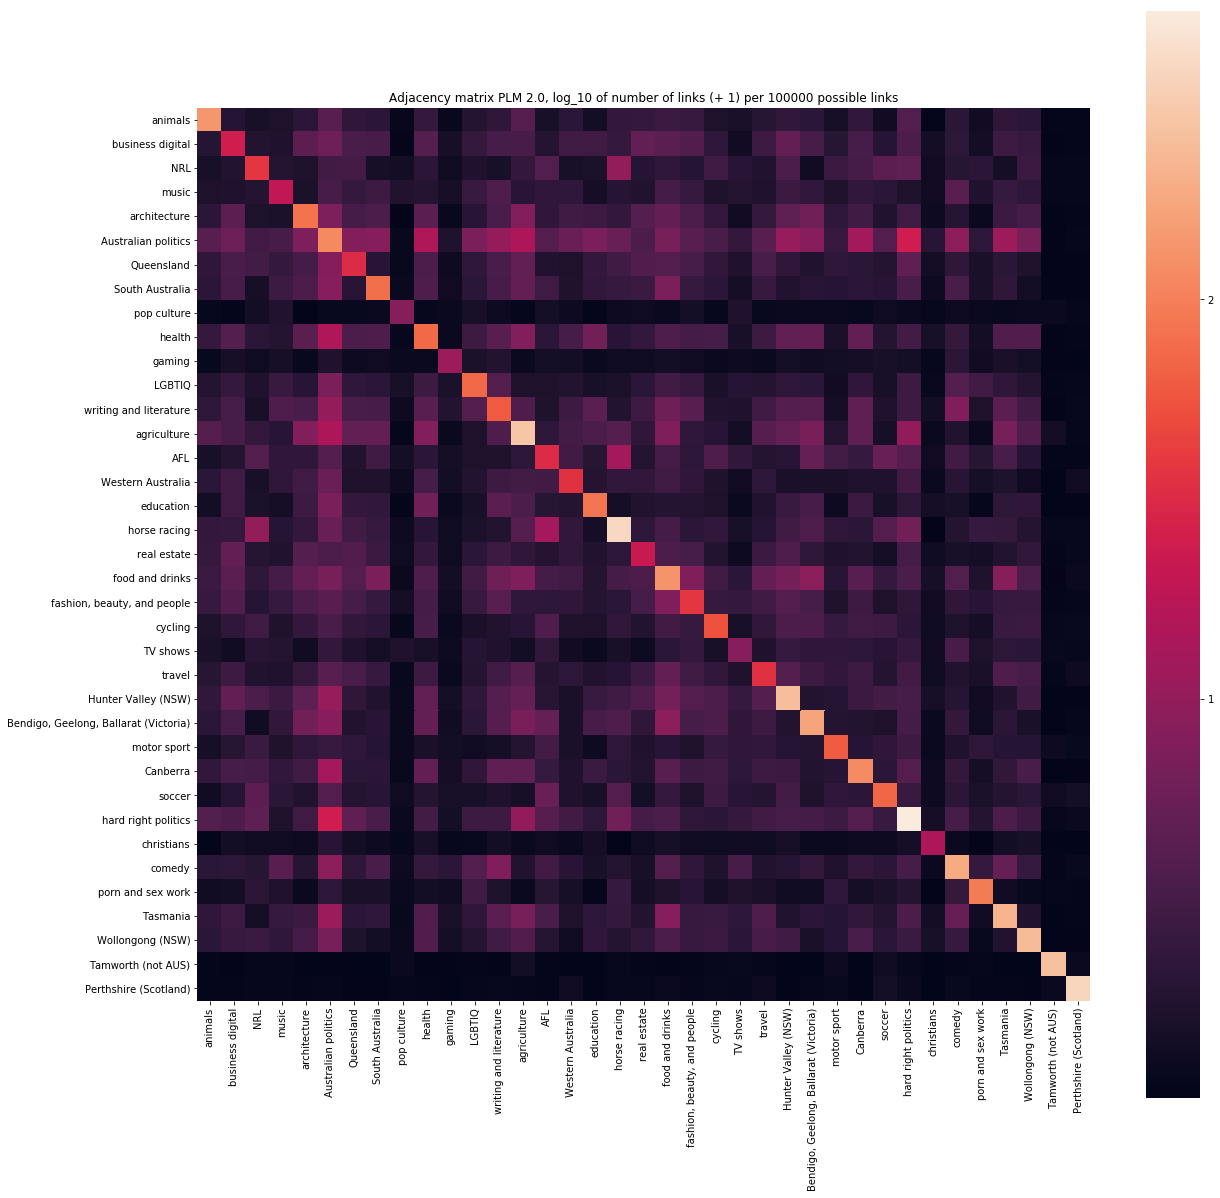

In [204]:
plot_filtered(matrix, numbers, log=True, per=100000, filter_groups=filter_groups)

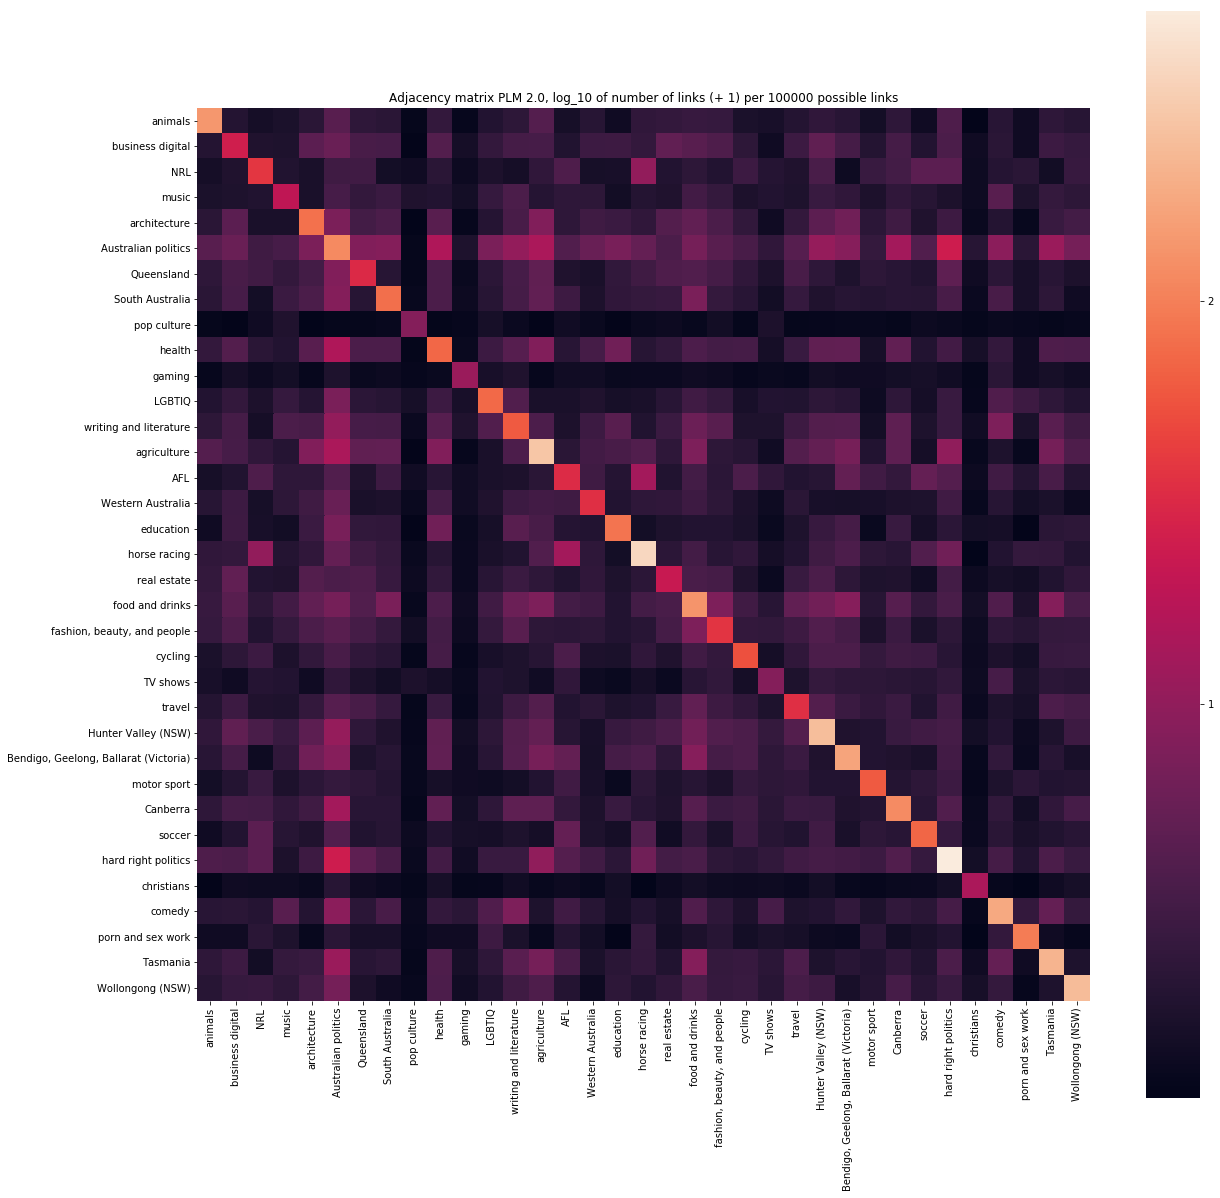

In [205]:
filter_strings = ['', 'not English', 'unclear', 'possible bots', 'potential bots', 'Tamworth (not AUS)',
                  'Perthshire (Scotland)']

filter_groups = get_filter_indices(filter_strings)

plot_filtered(matrix, numbers, log=True, per=100000, filter_groups=filter_groups)

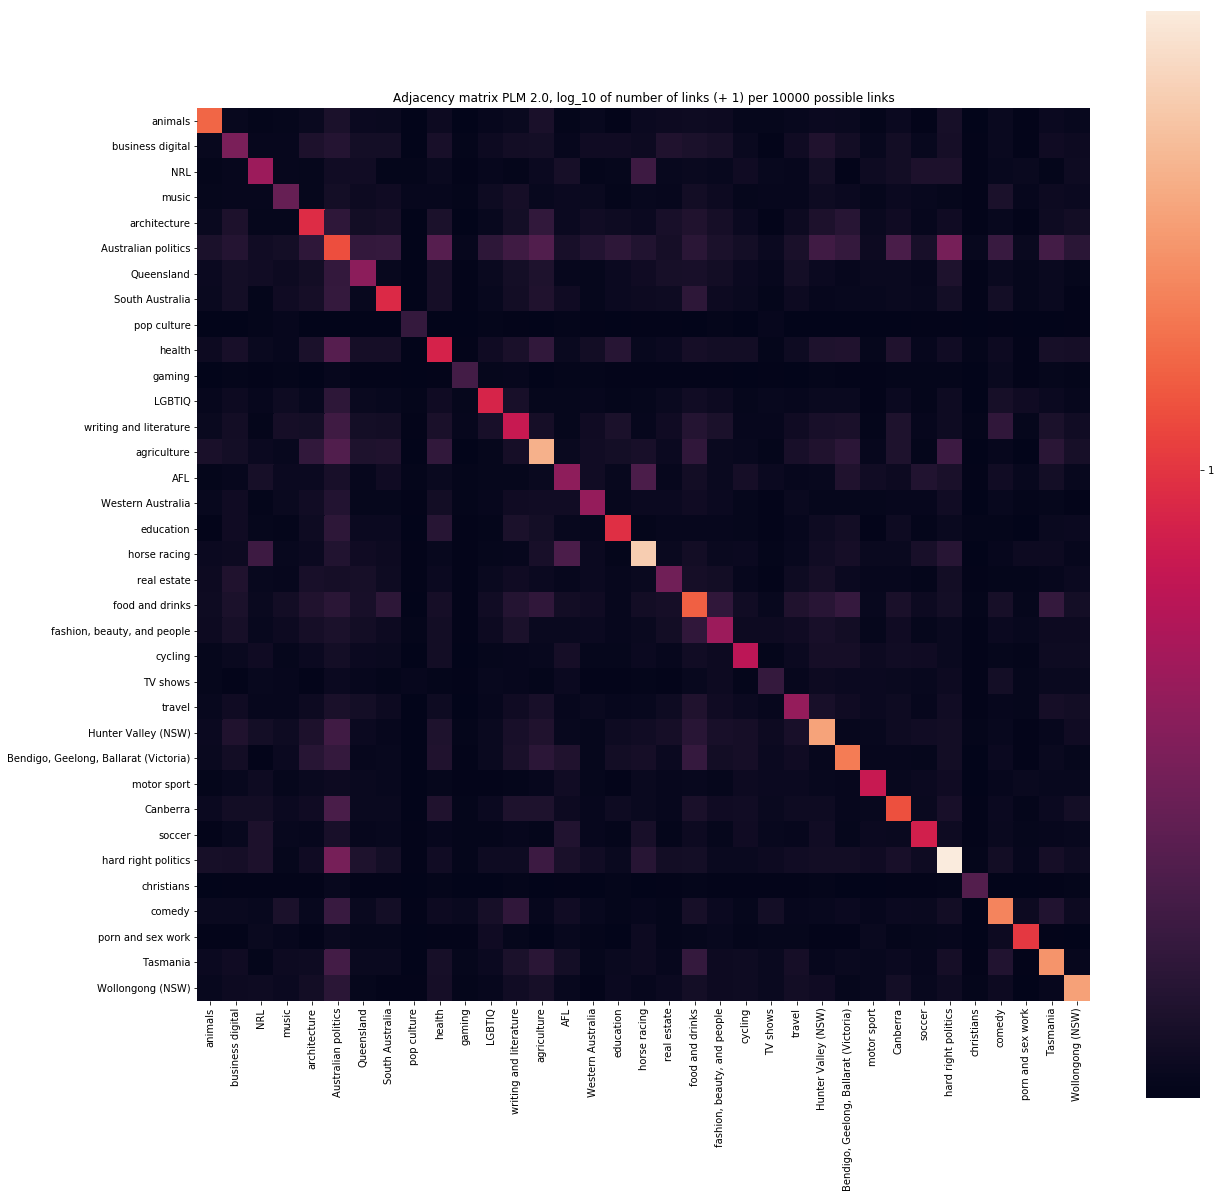

In [206]:
plot_filtered(matrix, numbers, log=True, per=10000, filter_groups=filter_groups)

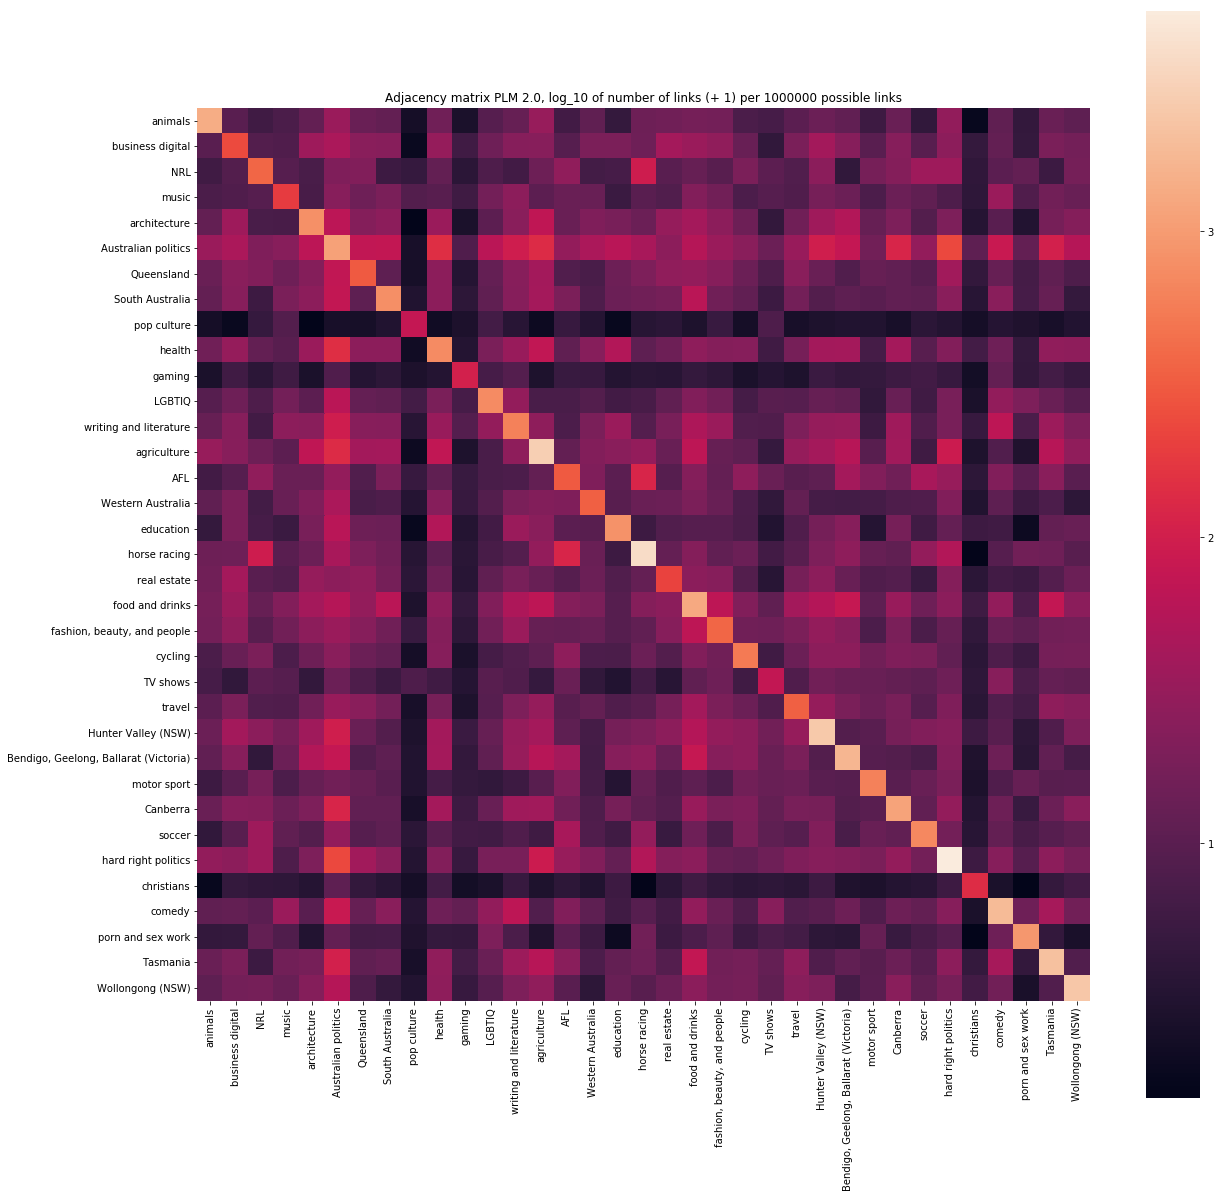

In [207]:
plot_filtered(matrix, numbers, log=True, per=1000000, filter_groups=filter_groups)

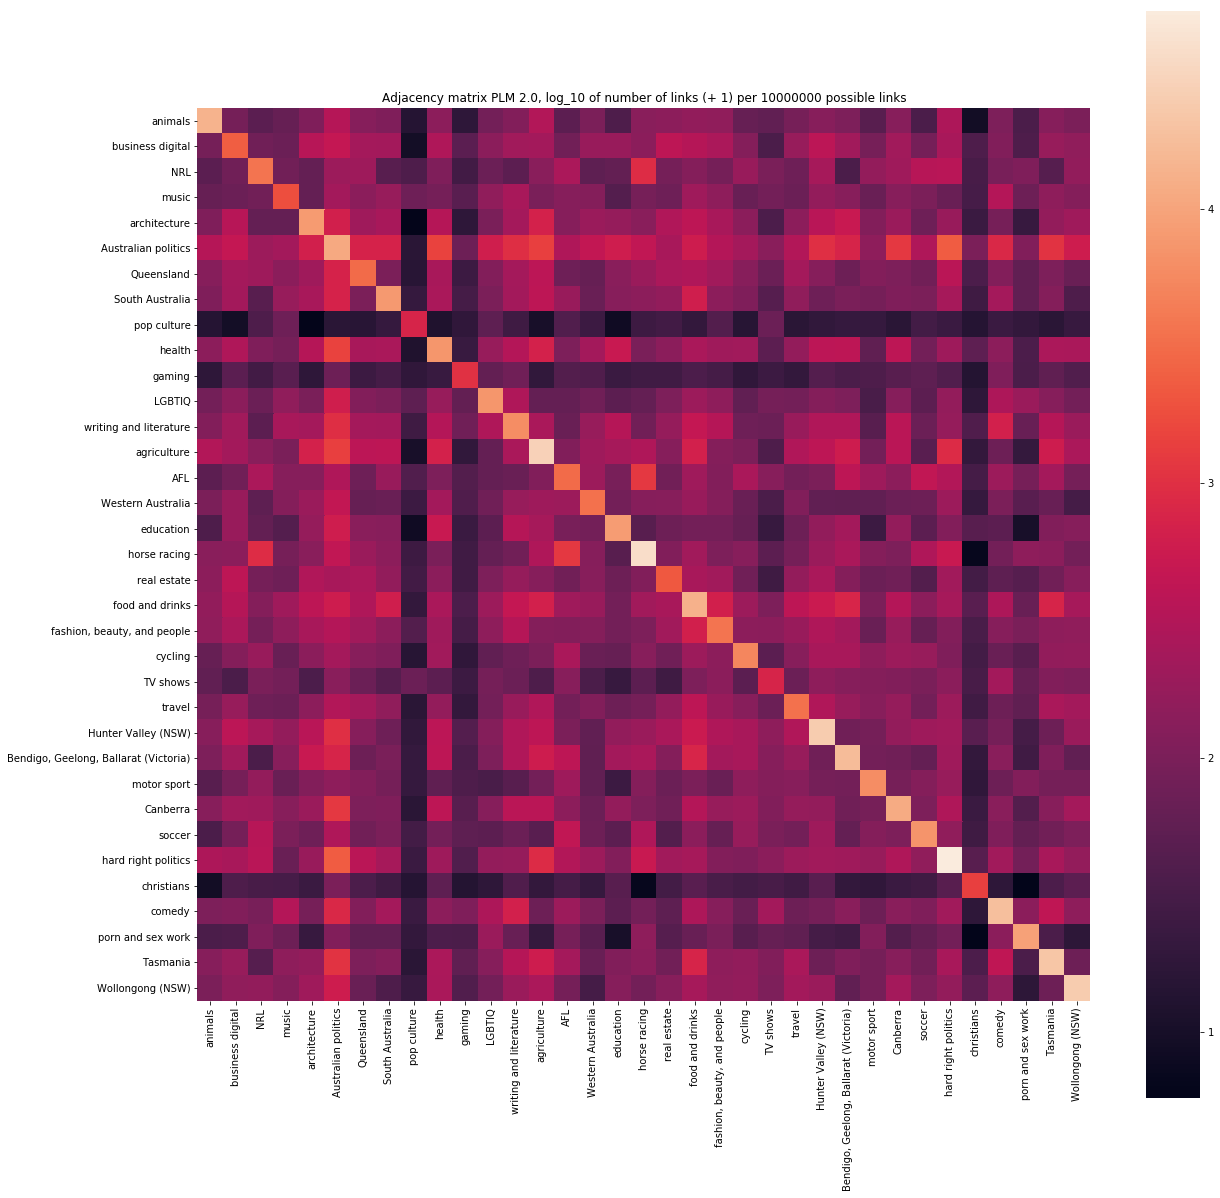

In [208]:
plot_filtered(matrix, numbers, log=True, per=10000000, filter_groups=filter_groups)

# Thought:

The higher `per` the more we see unconnected communities, the lower the easier it is to spot connected ones.